In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import os
import IPython.display as ipd 

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

from sklearn.model_selection import train_test_split


In [17]:
data = pd.DataFrame(columns = ['Emotion','Emotion_intensity','Actor_no','File'])
for dirname, _, filenames in os.walk('../project/data'):
    for filename in filenames:
        data = data.append({'Emotion':filename[6:8],'Emotion_intensity': filename[9:11], 'Actor_no':filename[-6:-4]
                            ,'File':os.path.join(dirname, filename)}, ignore_index= True)

data.head()

,Emotion,Emotion_intensity,Actor_no,File
0,07,02,16,../project/data/Actor_16/03-01-07-02-02-01-16.wav
1,08,01,16,../project/data/Actor_16/03-01-08-01-02-02-16.wav
2,06,01,16,../project/data/Actor_16/03-01-06-01-01-02-16.wav
3,03,02,16,../project/data/Actor_16/03-01-03-02-02-01-16.wav
4,02,01,16,../project/data/Actor_16/03-01-02-01-01-01-16.wav


In [18]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
def convert_labels(x):
    if x == '01':
        return 'neutral'
    elif x == '02':
        return 'calm'
    elif x == '03':
        return 'happy'
    elif x == '04':
        return 'sad'
    elif x == '05':
        return 'angry'
    elif x == '06':
        return 'fearful'
    elif x == '07':
        return 'disgust'
    elif x == '08':
        return 'surprised'
    
def convert_emotion_intensity(x):
    if x == '01':
        return 'Normal'
    elif x == '02':
        return 'Strong'

data['Emotion_intensity'] = data.apply(lambda x: convert_emotion_intensity(x['Emotion_intensity']), axis =1)    
data['Emotion'] = data.apply(lambda x: convert_labels(x['Emotion']), axis = 1)

In [19]:
def gender(x):
    x = int(x)
    if x %2 ==0:
        return 'Female'
    else:
        return 'Male'
    
data['Gender'] = data.apply(lambda x: gender(x['Actor_no']), axis =1)

In [20]:
data.head()

,Emotion,Emotion_intensity,Actor_no,File,Gender
0,disgust,Strong,16,../project/data/Actor_16/03-01-07-02-02-01-16.wav,Female
1,surprised,Normal,16,../project/data/Actor_16/03-01-08-01-02-02-16.wav,Female
2,fearful,Normal,16,../project/data/Actor_16/03-01-06-01-01-02-16.wav,Female
3,happy,Strong,16,../project/data/Actor_16/03-01-03-02-02-01-16.wav,Female
4,calm,Normal,16,../project/data/Actor_16/03-01-02-01-01-01-16.wav,Female


In [21]:
data.Emotion.value_counts()

surprised    384
sad          384
calm         384
happy        384
disgust      384
fearful      384
angry        384
neutral      192
Name: Emotion, dtype: int64

In [22]:
data.Emotion_intensity.value_counts()

Normal    1536
Strong    1344
Name: Emotion_intensity, dtype: int64

In [23]:
data.Gender.value_counts()

Male      1440
Female    1440
Name: Gender, dtype: int64

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential


In [25]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [26]:
def get_features(audio_data, sr):
    onset = np.mean(librosa.onset.onset_detect(audio_data,sr))
    mfccs = np.mean(librosa.feature.mfcc(audio_data, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data))
    spc = np.mean(librosa.feature.spectral_centroid(audio_data, sr))
    spr = np.mean(librosa.feature.spectral_rolloff(audio_data, sr))
    rms = np.mean(librosa.feature.rms(audio_data, sr))
    
    return [onset, mfccs, zcr, spc, spr, rms]

In [27]:
%%time
df = pd.DataFrame(columns =['Onset','MFCC', 'ZCR','SPC','SPR','RMS','Emotion'])
for i in range(len(data)):
    audio_data, sr = librosa.load(data.File[i])
    
    features = get_features(audio_data, sr)
    df = df.append({'Onset': features[0],'MFCC': features[1], 'ZCR': features[2],'SPC': features[3],'SPR':features[4]
                    ,'RMS': features[5],'Emotion':data['Emotion'][i]}
                    ,ignore_index=True)
    
    new = noise(audio_data)
    features = get_features(new, sr)
    df = df.append({'Onset': features[0],'MFCC': features[1], 'ZCR': features[2],'SPC': features[3],'SPR':features[4]
                    ,'RMS': features[5],'Emotion':data['Emotion'][i]}
                    ,ignore_index=True)
    new = stretch(audio_data)
    features = get_features(new, sr)
    df = df.append({'Onset': features[0],'MFCC': features[1], 'ZCR': features[2],'SPC': features[3],'SPR':features[4]
                    ,'RMS': features[5],'Emotion':data['Emotion'][i]}
                    ,ignore_index=True)
    new = shift(audio_data)
    features = get_features(new, sr)
    df = df.append({'Onset': features[0],'MFCC': features[1], 'ZCR': features[2],'SPC': features[3],'SPR':features[4]
                    ,'RMS': features[5],'Emotion':data['Emotion'][i]}
                    ,ignore_index=True)
    new = pitch(audio_data, sr)
    features = get_features(new, sr)
    df = df.append({'Onset': features[0],'MFCC': features[1], 'ZCR': features[2],'SPC': features[3],'SPR':features[4]
                    ,'RMS': features[5],'Emotion':data['Emotion'][i]}
                    ,ignore_index=True)
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
CPU times: user 1h 15min 16s, sys: 1h 25min 17s, total: 2h 40min 33s
Wall time: 44min 9s


In [28]:
df.shape

(14400, 7)

In [29]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state =42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state =42)

In [31]:
# %%time
# from sklearn import svm

# parameters = {
    
#     'C': [ 2,2.5, 3],
#     'gamma': [ 0.2, 0.3,0.1, 0.01,0.001,0.02, 'scale'],
#     'kernel': ['rbf', 'linear', 'sigmoid'],
#     'class_weight': ['balanced']

# }
# grid_model = svm.SVC()
# grid_svc = GridSearchCV(grid_model, parameters, n_jobs=-1)

# print("Grid Search Done")
# grid_svc.fit(X_train,y_train)

# print("fit")
# yt_p = grid_svc.predict(X_train)
# yv_p = grid_svc.predict(X_val)

# print('Training Accuracy', np.mean(yt_p==y_train))
# print('Validation  Accuracy', np.mean(yv_p==y_val))

# #Scores and best model
# print (grid_svc.best_score_)
# print (grid_svc.best_params_)

In [44]:
#Best Model
from sklearn import svm
model  = svm.SVC(C=2.5, gamma=0.01, kernel='rbf', class_weight='balanced')
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.9974922839506173
Validation  Accuracy 0.6030092592592593


In [45]:
pred = model.predict(X_test)

print('Testing Accuracy', np.mean(pred==y_test))

Testing Accuracy 0.6333333333333333


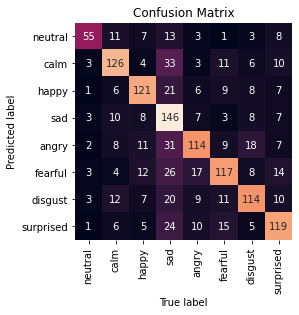

In [47]:
#Confusion Matrix
classes = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

x = metrics.confusion_matrix(y_test, pred, labels = classes)
y = metrics.confusion_matrix(y_train, yt_p, labels = classes)

sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
           xticklabels = classes,
            yticklabels = classes
           )
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("Confusion Matrix")
plt.show()

### Naive

In [35]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)

yt_p = gnb.predict(X_train)
yv_p = gnb.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.23350694444444445
Validation  Accuracy 0.23726851851851852


In [36]:
pred = gnb.predict(X_test)

print('Testing Accuracy', np.mean(pred==y_test))

Testing Accuracy 0.2263888888888889


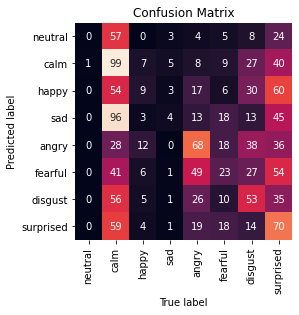

In [39]:
classes = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

x = metrics.confusion_matrix(y_test, pred, labels = classes)
y = metrics.confusion_matrix(y_train, yt_p, labels = classes)

sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
           xticklabels = classes,
            yticklabels = classes
           )
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("Confusion Matrix")
plt.show()

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.33      0.34      0.34       200
        calm       0.20      0.51      0.29       196
       happy       0.25      0.28      0.27       186
         sad       0.21      0.11      0.15       201
       angry       0.20      0.05      0.08       179
     fearful       0.00      0.00      0.00       101
     disgust       0.22      0.02      0.04       192
   surprised       0.19      0.38      0.26       185

    accuracy                           0.23      1440
   macro avg       0.20      0.21      0.18      1440
weighted avg       0.22      0.23      0.19      1440

